# Aplicação do algoritmo de _Gale-Shapley_ para recomendações de **Influenciadores, Anúncios e Comerciantes**

Neste exemplo iremos resolver o problema de gerar recomendações de Influenciadores para Comerciantes de Anúncios utilizando dados tabulares, cobrindo aspectos de manipulação dos dados e interpretação dos resultados.

In [1]:
# Hack para instalar a lib
import sys
!{sys.executable} -m pip install galeshapley --upgrade

In [2]:
from galeshapley.games import PlayerAllocation

In [3]:
import numpy as np
import pandas as pd

In [4]:
raw_influenciadores = pd.read_csv("https://zenodo.org/record/5799703/files/influenciadores.csv")
display(raw_influenciadores.head())

# ("./data/produtos.csv")
raw_anuncios = pd.read_csv("https://zenodo.org/record/5799703/files/produtos.csv")
display(raw_anuncios.head())

raw_comerciantes = pd.read_csv("https://zenodo.org/record/5799703/files/comerciantes.csv")
display(raw_comerciantes.head())

,nome,rank,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,190000,3,G2,P1,V2,S0,A0,O0,L0,D2,...,K0,X0,O1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,190001,56,Q0,P1,P0,M1,N0,P1,T2,N1,...,C0,Z0,L0,H2,NaN,NaN,NaN,NaN,NaN,NaN
2,190002,60,D0,U0,Y1,E2,R0,P0,V1,R2,...,A1,I2,N1,A0,J2,A0,NaN,NaN,NaN,NaN
3,190003,67,C0,J1,I2,N1,W1,E1,M1,Z1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,190004,19,I0,M1,C2,D0,W0,F1,B2,O1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,codigo,quota,comerciante
0,A0,2,A
1,A1,3,A
2,A2,2,A
3,B0,2,B
4,B1,2,B


,nome,quota
0,A,3
1,B,1
2,C,8
3,D,5
4,E,2


## Limpeza dos dados

Os dados devem ser pré-processados para removermos dados inválidos.

### Influenciadores

Começamos pelos influenciadores e calculamos quantas opções cada um possui na tabela

In [5]:
raw_influenciadores.columns

Index(['nome', 'rank', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24'],
      dtype='object')

Nossa tabela permite que cada influenciador liste até 25 anuncios desejados, numerados de 0 a 24:

In [6]:
n_choices = 25
choices = map(str, range(n_choices))

Eliminamos influencaidores que não possuem anuncios:

In [7]:
influenciadores = raw_influenciadores.copy()
influenciadores = influenciadores.dropna(subset = choices, how = "all").reset_index(drop = True)

influenciadores.head()

,nome,rank,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,190000,3,G2,P1,V2,S0,A0,O0,L0,D2,...,K0,X0,O1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,190001,56,Q0,P1,P0,M1,N0,P1,T2,N1,...,C0,Z0,L0,H2,NaN,NaN,NaN,NaN,NaN,NaN
2,190002,60,D0,U0,Y1,E2,R0,P0,V1,R2,...,A1,I2,N1,A0,J2,A0,NaN,NaN,NaN,NaN
3,190003,67,C0,J1,I2,N1,W1,E1,M1,Z1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,190004,19,I0,M1,C2,D0,W0,F1,B2,O1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Contabilizamos o que foi perdido:

In [8]:
len(raw_influenciadores) - len(influenciadores)

3

### Anúncios

Cada anúncio requer um nome único e uma capacidade maior que zero. Observe que dois comerciantes podem revender a mesma marca e qualidade de um anúncio, mas na prática são anúncios diferentes na perspectiva do influenciador (_uma coisa é representar uma marca de tênis esportivo famosa por uma loja local e outra diferente é representar a marca nacionalmente por uma rede de lojas de departamento ou mundialmente  pelo fabricante_):

In [9]:
anuncios = raw_anuncios.copy()
anuncios = anuncios.dropna()
anuncios = anuncios[anuncios["quota"] > 0]

anuncios.head()

,codigo,quota,comerciante
0,A0,2,A
1,A1,3,A
2,A2,2,A
3,B0,2,B
4,B1,2,B


Contabilizar quantos anúncios foram perdidos:

In [10]:
len(raw_anuncios) - len(anuncios)

0

### Comerciantes

Cada comerciante requer uma identificação única e uma capacidade diferente de zero e qualquer um que não atenda estas características é eliminado:

In [11]:
comerciantes = raw_comerciantes.copy()
comerciantes = comerciantes.dropna()
comerciantes = comerciantes[comerciantes["quota"] > 0]

comerciantes.head()

,nome,quota
0,A,3
1,B,1
2,C,8
3,D,5
4,E,2


Contabilizar quantos comerciantes perdemos:

In [12]:
len(comerciantes) - len(raw_comerciantes)

0

## Criação dos dicionários de dados

A API trabalha com dicionários que devem ser criados e que irão conter as seguintes relações:

* Relações entre anúncios e comerciantes e influenciadores
* Capacidades por anúncios de cada comerciante
* Lista de preferências de influenciadores e comerciantes
* Capacidades dos comerciantes

### Capacidades e relações

Iremos iniciar com a capacidade e relações entre anúncios e comerciantes

In [13]:
comerciante_nomes = comerciantes["nome"].values
anuncio_codigos = anuncios["codigo"].values

In [14]:
anuncio_to_quota, anuncio_to_comerciante = {}, {}
for _, (anuncio, quota, comerciante) in anuncios.iterrows():
    if anuncio in anuncio_codigos and comerciante in comerciante_nomes:
        anuncio_to_comerciante[anuncio] = comerciante
        anuncio_to_quota[anuncio] = quota

Agora podemos criar o dicionário com a capacidade de cada comerciante. Incluimos apenas os comerciantes que possuem ao menos um anúncio válido:

In [15]:
comerciante_to_quota = {}
for _, (comerciante, quota) in comerciantes.iterrows():
    if comerciante in anuncio_to_comerciante.values():
        comerciante_to_quota[comerciante] = quota

## Listas de preferências

Os dicionários remanescentes irão conter a lista de preferências dos influenciadores e comerciantes.

Iniciando pelo influenciadores, estes devem possuir uma lista de anúncios válidos.

> _Caso de mais de um influenciador listar o mesmo anúncio, iremos utilizar o atributo **rank** para dar preferência para o que estiver mais alto na qualificação_.

In [16]:
influenciador_prefs = {}
for _, (influenciador, _, *prefs) in influenciadores.iterrows():
    influenciador_preferences = []
    for anuncio in prefs:
        if anuncio in anuncio_codigos and anuncio not in influenciador_preferences:
            influenciador_preferences.append(anuncio)

    if influenciador_preferences:
        influenciador_prefs[influenciador] = influenciador_preferences

In [17]:
sorted_influenciadores = influenciadores.sort_values("rank", ascending = True)["nome"].values

> Se um influenciador listou vários anúncios do mesmo comerciante, ele somente será listado uma vez para aquele comerciante.

In [18]:
comerciante_prefs = {}
for comerciante in comerciante_nomes:

    comerciante_preferences = []
    comerciante_anuncios = [
        p for p, s in anuncio_to_comerciante.items() if s == comerciante
    ]

    for influenciador in sorted_influenciadores:
        influenciador_preferences = influenciador_prefs[influenciador]
        if set(influenciador_preferences).intersection(comerciante_anuncios):
            comerciante_preferences.append(influenciador)

    if comerciante_preferences:
        comerciante_prefs[comerciante] = comerciante_preferences

## Limpeza final

### Removendo influenciadores extras

Devemos rever as preferências dos comerciantes para remover qualquer um que ficou com sua lista vazia. Do mesmo modo da lista de anúncios os que não possuem influenciadores interessados devem ser removidos. 

In [19]:
unranked_comerciantes = set(comerciante_nomes).difference(
    comerciante_prefs.keys()
)


unranked_anuncios = set(anuncio_codigos).difference(
    (anuncio for prefs in influenciador_prefs.values() for anuncio in prefs)
)

unranked_comerciantes, unranked_anuncios

(set(), {'L1'})

In [20]:
for comerciante in unranked_comerciantes:
    del comerciante_to_quota[comerciante]

for anuncio in unranked_anuncios:
    del anuncio_to_quota[anuncio]
    del anuncio_to_comerciante[anuncio]

### Verificando e ajustando as capacidades

O passo final será ajustar as capacidades:

1. Cada anúncio não deve suportar mais influenciadores que o próprio comerciante suporta;
2. A capacidade de cada comerciante deve:
    * Tão grande quanto a maior capacidade da lista de seus anúncios; e
    * Não deve ser maior que a soma das capacidades de seus anúncios.

Começamos reduzindo as capacidades muito grandes dos anúncios:

In [21]:
for anuncio, anuncio_quota in anuncio_to_quota.items():
    comerciante = anuncio_to_comerciante[anuncio]
    comerciante_quota = comerciante_to_quota[comerciante]

    if anuncio_quota > comerciante_quota:
        print(
            f"anúncio {anuncio} possui {anuncio_quota} espaço(s) para influenciador(es) porém o comerciante",
            f"{comerciante} possui somente {comerciante_quota} espaço(s).",
        )
        anuncio_to_quota[anuncio] = comerciante_quota

anúncio B0 possui 2 espaço(s) para influenciador(es) porém o comerciante B possui somente 1 espaço(s).
anúncio B1 possui 2 espaço(s) para influenciador(es) porém o comerciante B possui somente 1 espaço(s).
anúncio B2 possui 2 espaço(s) para influenciador(es) porém o comerciante B possui somente 1 espaço(s).
anúncio E1 possui 3 espaço(s) para influenciador(es) porém o comerciante E possui somente 2 espaço(s).
anúncio E2 possui 3 espaço(s) para influenciador(es) porém o comerciante E possui somente 2 espaço(s).
anúncio F1 possui 3 espaço(s) para influenciador(es) porém o comerciante F possui somente 2 espaço(s).
anúncio I1 possui 2 espaço(s) para influenciador(es) porém o comerciante I possui somente 1 espaço(s).
anúncio I2 possui 2 espaço(s) para influenciador(es) porém o comerciante I possui somente 1 espaço(s).
anúncio M0 possui 8 espaço(s) para influenciador(es) porém o comerciante M possui somente 7 espaço(s).
anúncio O1 possui 2 espaço(s) para influenciador(es) porém o comerciante 

Agora certificamos que nenhum comerciante possui mais espaços disponíveis do que ele oferece em seus anúncios:

In [22]:
for comerciante, comerciante_quota in comerciante_to_quota.items():

    comerciante_anuncios = [
        p for p, s in anuncio_to_comerciante.items() if s == comerciante
    ]
    comerciante_anuncio_capacities = [
        anuncio_to_quota[anuncio] for anuncio in comerciante_anuncios
    ]

    if comerciante_quota > sum(comerciante_anuncio_capacities):
        print(
            f"o comerciante {comerciante} possui {comerciante_quota} espaço(s) porém seus anúncios",
            f"({', '.join(comerciante_anuncios)}) possuem um total de",
            f"{sum(comerciante_anuncio_capacities)} espaços.",
        )
        comerciante_to_quota[comerciante] = sum(comerciante_anuncio_capacities)

o comerciante K possui 8 espaço(s) porém seus anúncios (K0, K1, K2) possuem um total de 6 espaços.
o comerciante L possui 2 espaço(s) porém seus anúncios (L0) possuem um total de 1 espaços.
o comerciante W possui 5 espaço(s) porém seus anúncios (W0, W1) possuem um total de 2 espaços.


## Executando o algoritmo

Agora que as estruturas de dados estão prontas utilizamos os dicionários construídos para gerar as recomendações. A recomendação poderá ser otimizada por influenciador ou por comerciante. Faremos por influenciador.

In [23]:
import pprint

# pprint.pprint(influenciador_prefs)
# pprint.pprint(comerciante_prefs)
# pprint.pprint(anuncio_to_comerciante)
# pprint.pprint(anuncio_to_quota)
# pprint.pprint(comerciante_to_quota)

game = PlayerAllocation.create_from_dictionaries(
    influenciador_prefs,
    comerciante_prefs,
    anuncio_to_comerciante,
    anuncio_to_quota,
    comerciante_to_quota,
)

# matching = game.solve(optimal = "player")
matching = game.solve(optimal = "container")
assert game.check_validity()
assert game.check_stability()

In [24]:
matching

{A0: [], A1: [190019, 190034], A2: [190017], B0: [], B1: [190091], B2: [], C0: [190003, 190068], C1: [190070], C2: [190079, 190062], D0: [190015, 190039, 190009], D1: [190008, 190056], D2: [], E0: [], E1: [190063, 190022], E2: [], F0: [190011], F1: [190094], G0: [190096], G1: [], G2: [190000, 190045, 190077], H0: [], H1: [190078], H2: [190023, 190098], I0: [190004], I1: [], I2: [], J0: [190021], J1: [190097, 190089, 190061, 190014], J2: [190085, 190090], K0: [190074, 190095], K1: [190024, 190013], K2: [190052, 190006], L0: [190072], M0: [190086, 190053], M1: [190054, 190081, 190075], N0: [190049, 190032], N1: [190046, 190044, 190037, 190057], N2: [190031, 190060], O0: [190016], O1: [], P0: [190047], P1: [190076, 190027], P2: [190093], P3: [190071], Q0: [190001], R0: [190048], R1: [], R2: [], S0: [190069], S1: [190092, 190042, 190084, 190066, 190067], T0: [], T1: [], T2: [190036], U0: [190010, 190002, 190059, 190030], U1: [], U2: [190055], V0: [190073], V1: [], V2: [190018], W0: [190026

## Análise

O resultado obtido não é trivial de ser lido e portanto utilizaremos visualizações para facilitar a interpretação

In [25]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

plt.style.use("seaborn-colorblind")
%matplotlib inline

### Comerciantes

Apresentamos a utilização dos comerciantes:

In [26]:
comerciante_free_spaces = {
    comerciante: comerciante.capacity - len(comerciante.matching)
    for comerciante in game.containers
}

comerciante_utilisation = {
    comerciante: len(comerciante.matching) / comerciante.capacity
    for comerciante in game.containers
}

Text(0.5, 1.0, 'Comerciante - Espaços Livres')

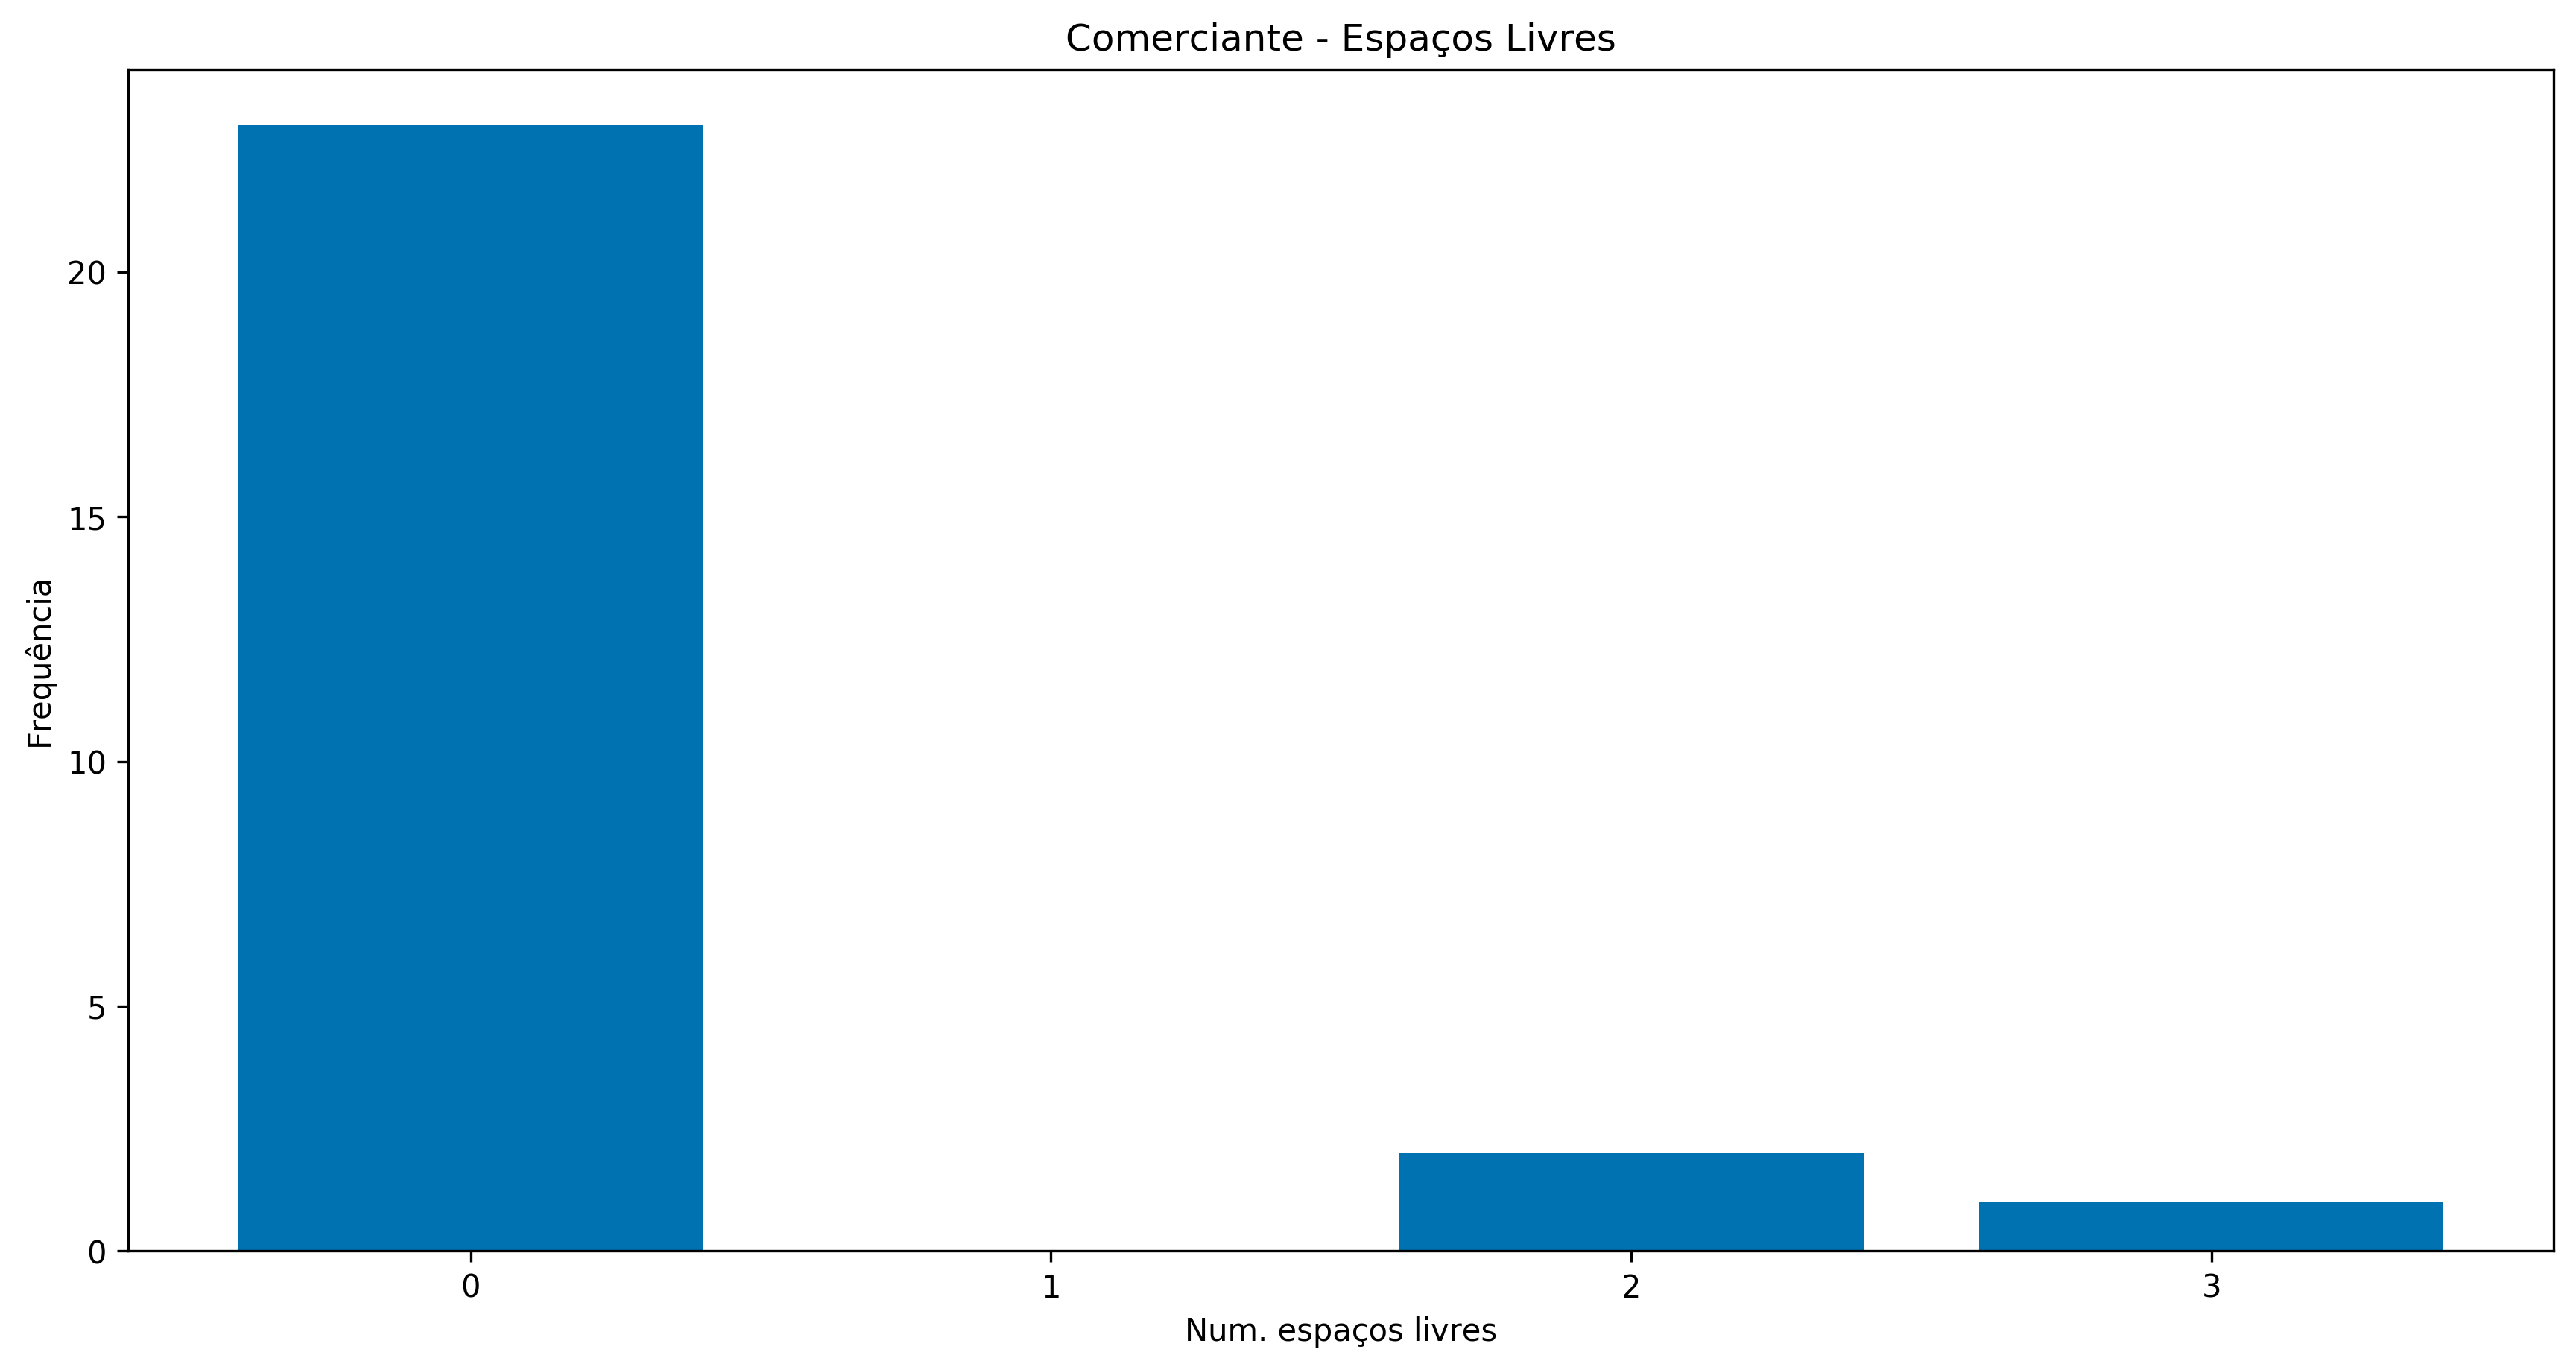

In [27]:
fig, ax = plt.subplots(figsize = (14, 7), dpi = 300)

data = Counter(comerciante_free_spaces.values())
ax.bar(data.keys(), data.values())

ax.set_xlabel("Num. espaços livres")
ax.set_ylabel("Frequência")
ax.set_xticks(range(max(data.keys()) + 1))
ax.set_title("Comerciante - Espaços Livres")

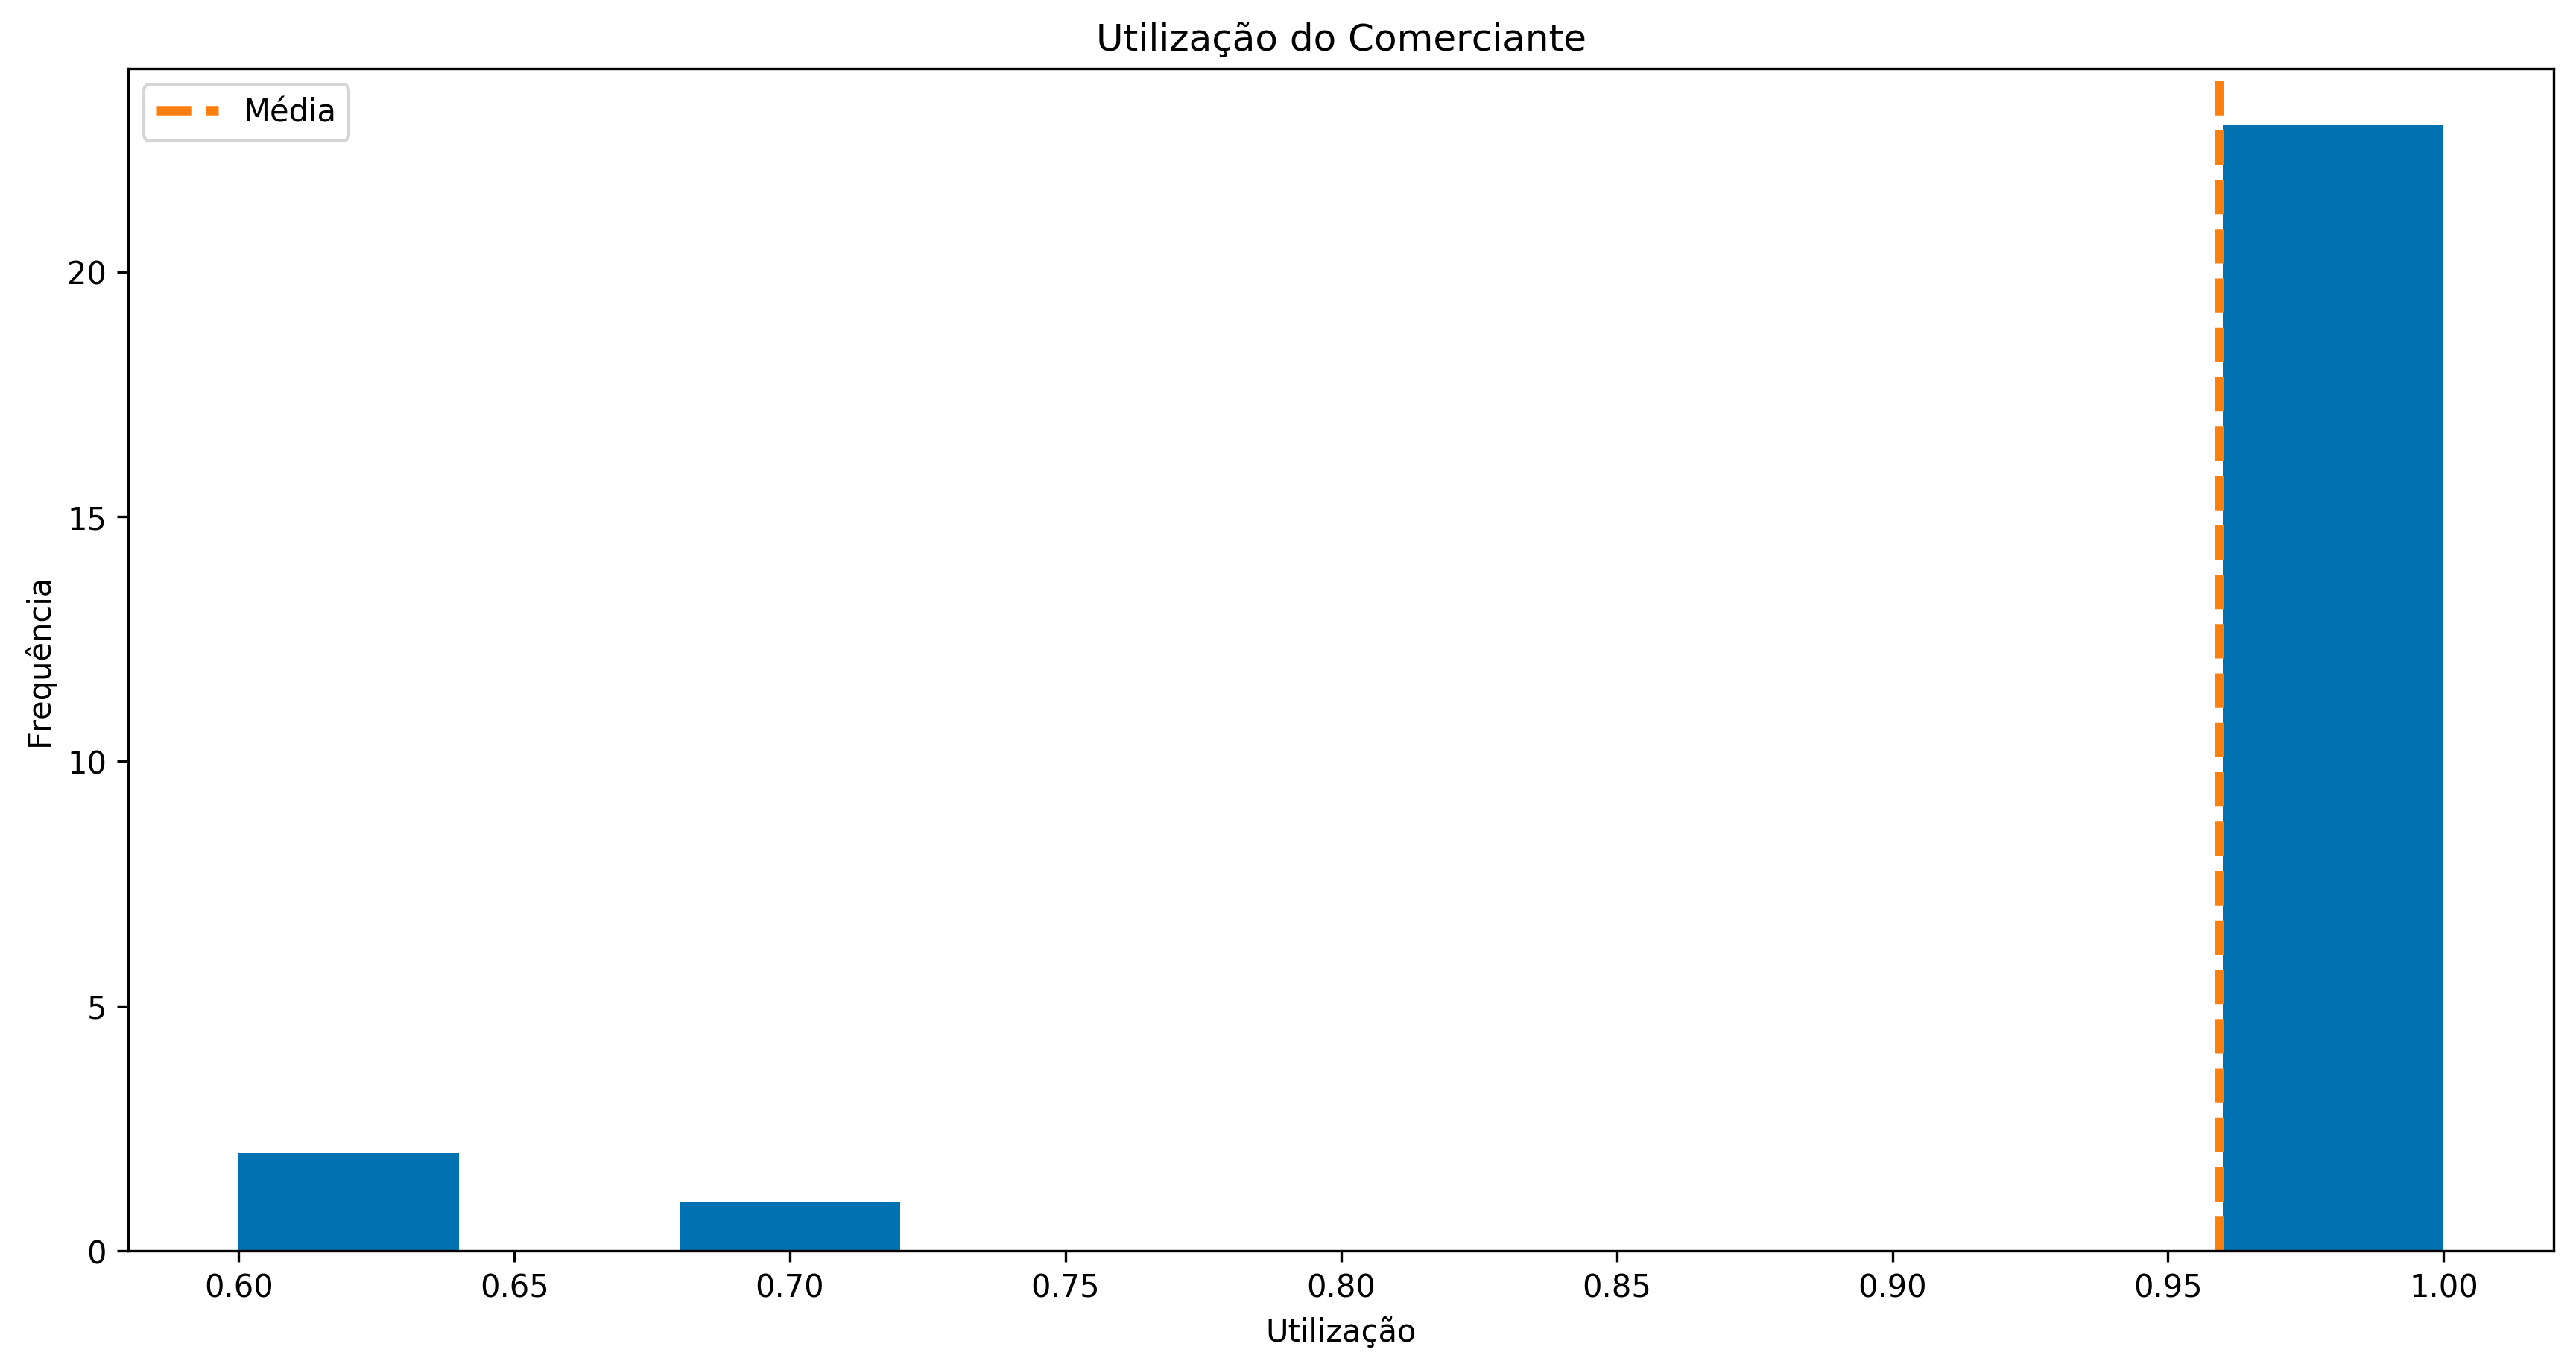

In [28]:
fig, ax = plt.subplots(figsize = (14, 7), dpi = 300)

values = comerciante_utilisation.values()
ax.hist(values)

ylims = ax.get_ylim()
ax.vlines(np.mean(list(values)), *ylims, "tab:orange", "dashed", label = "Média", lw = 3)
ax.set_ylim(*ylims)

ax.set_xlabel("Utilização")
ax.set_ylabel("Frequência")
ax.set_title("Utilização do Comerciante")
ax.legend()

Podemos observar que os comerciantes aproveitaram quase que totalmente sua capacidade de alocar influenciadores.

### Anúncios

A mesma visualização aplicada aos anúncios:

In [29]:
anuncio_free_spaces = {
    resource.name: resource.capacity - len(resource.matching) for resource in game.resources
}

anuncio_utilisation = {
    resource.name: len(resource.matching) / resource.capacity for resource in game.resources
}

Text(0.5, 1.0, 'Espaços Livres de Anúncios')

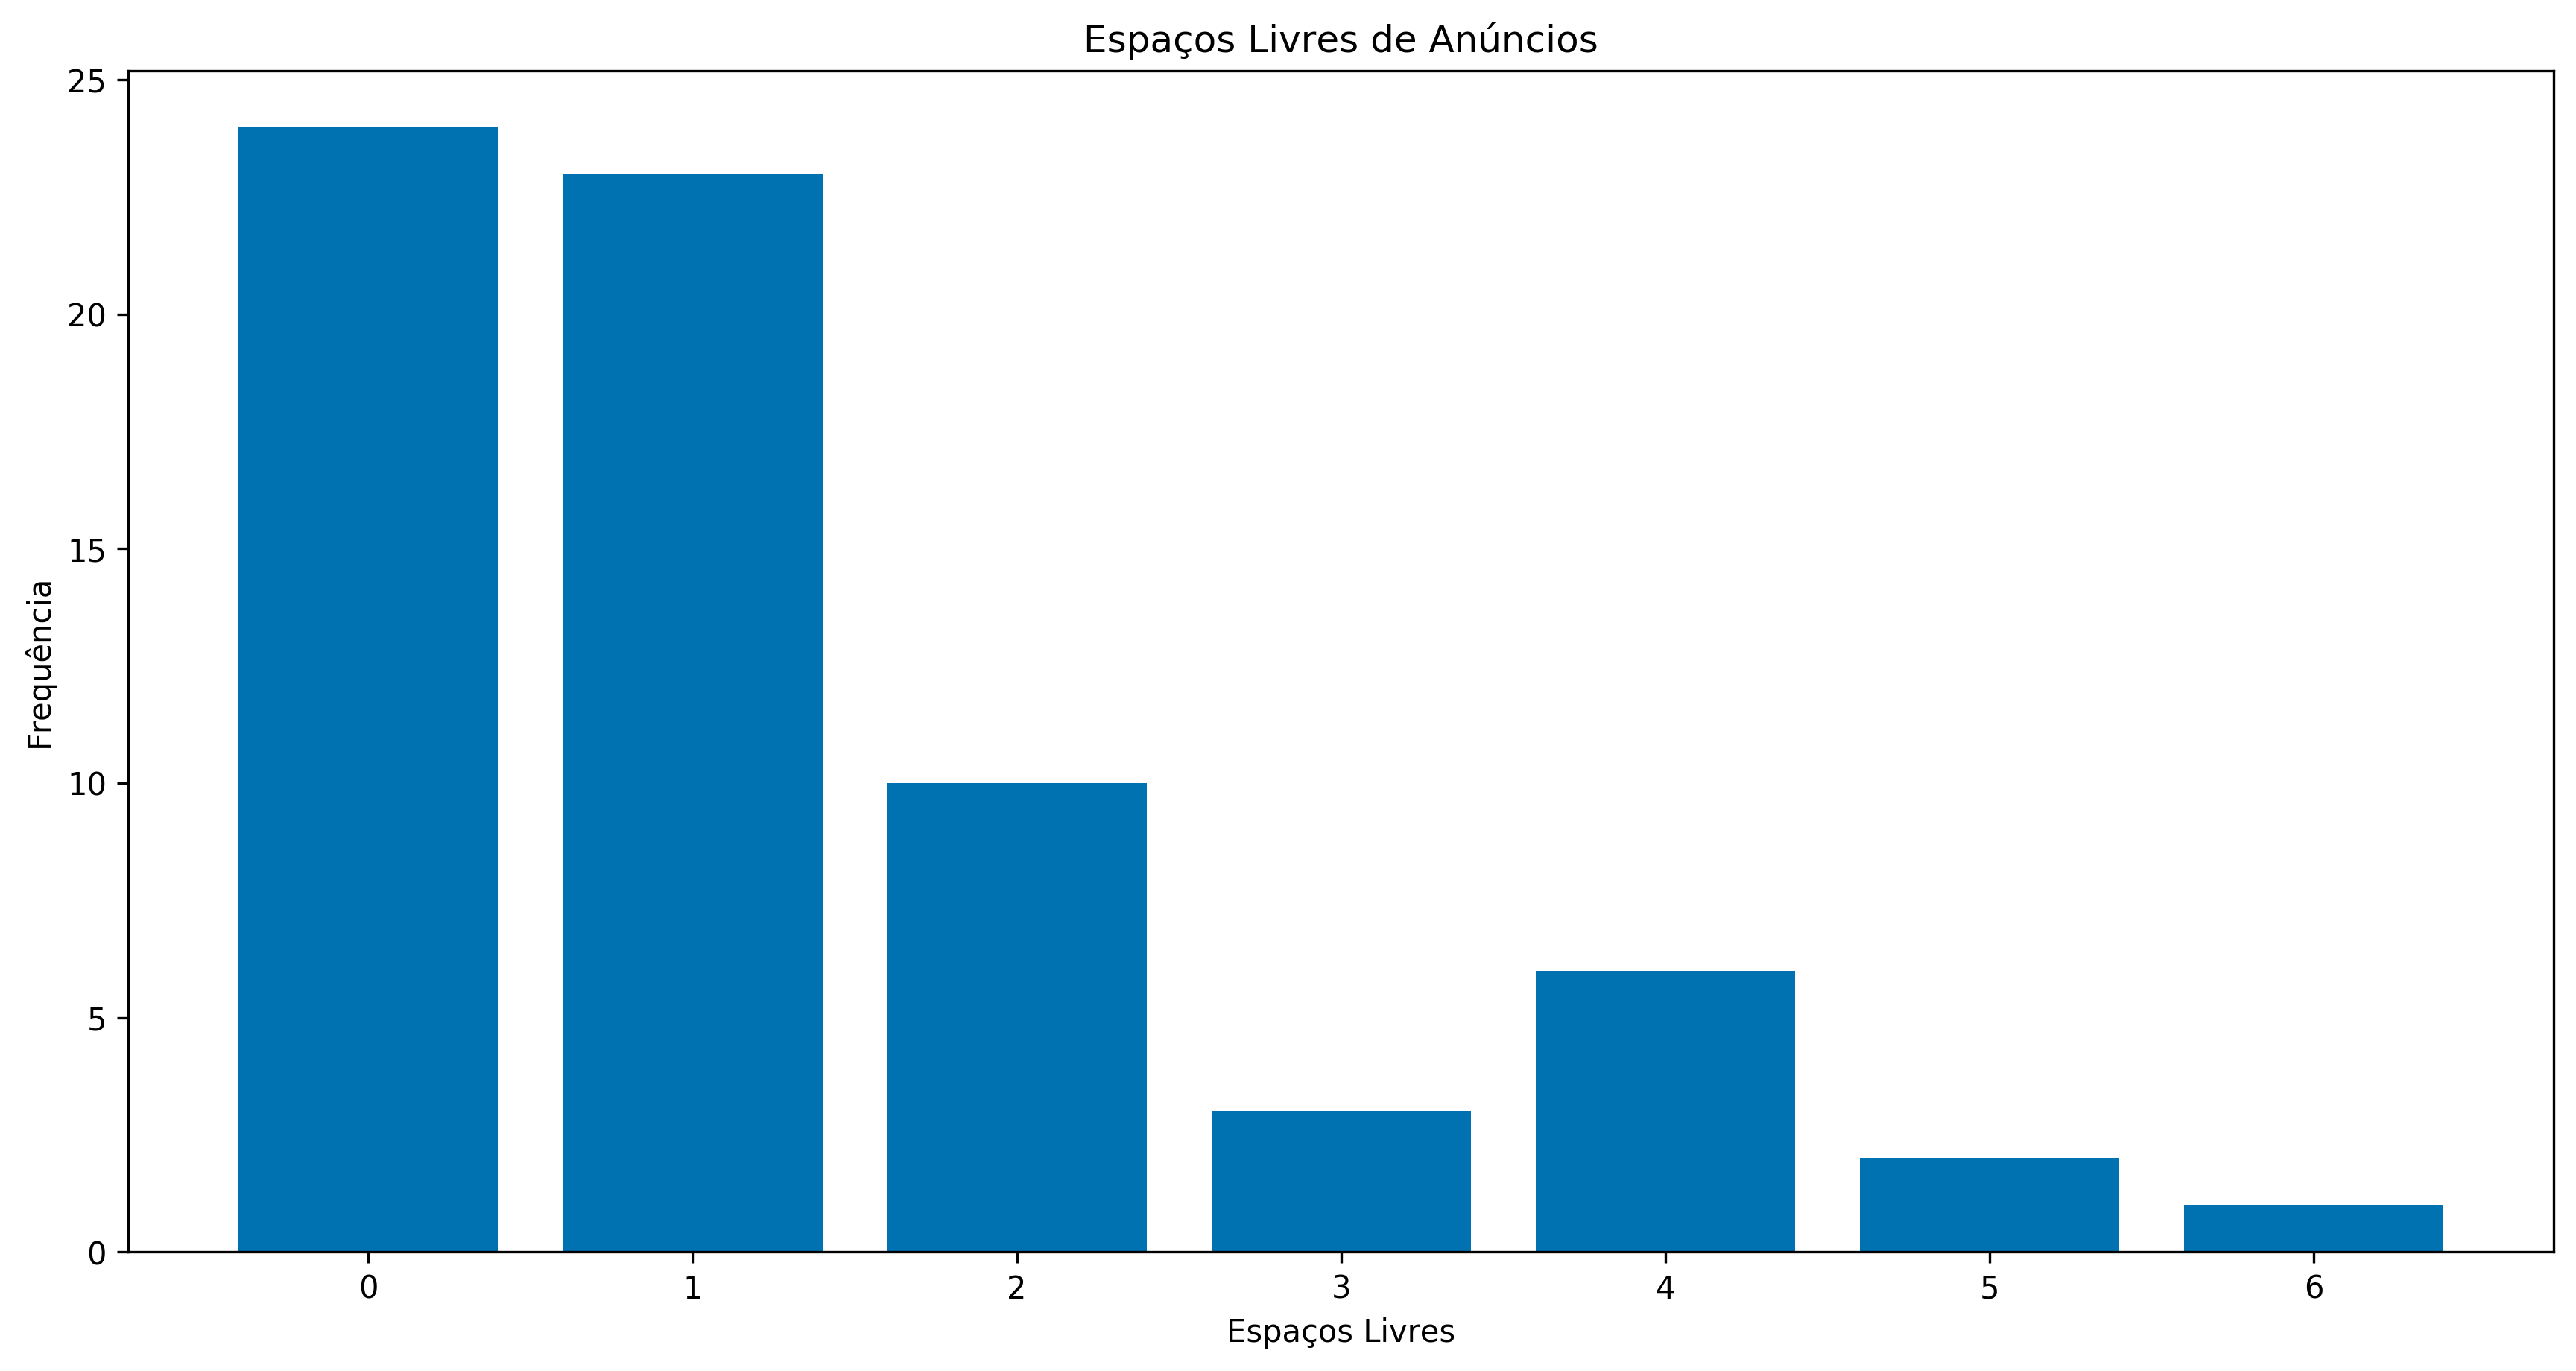

In [30]:
fig, ax = plt.subplots(figsize = (14, 7), dpi = 300)

data = Counter(anuncio_free_spaces.values())
ax.bar(data.keys(), data.values())

ax.set_xlabel("Espaços Livres")
ax.set_ylabel("Frequência")
ax.set_xticks(range(max(data.keys()) + 1))
ax.set_title("Espaços Livres de Anúncios")

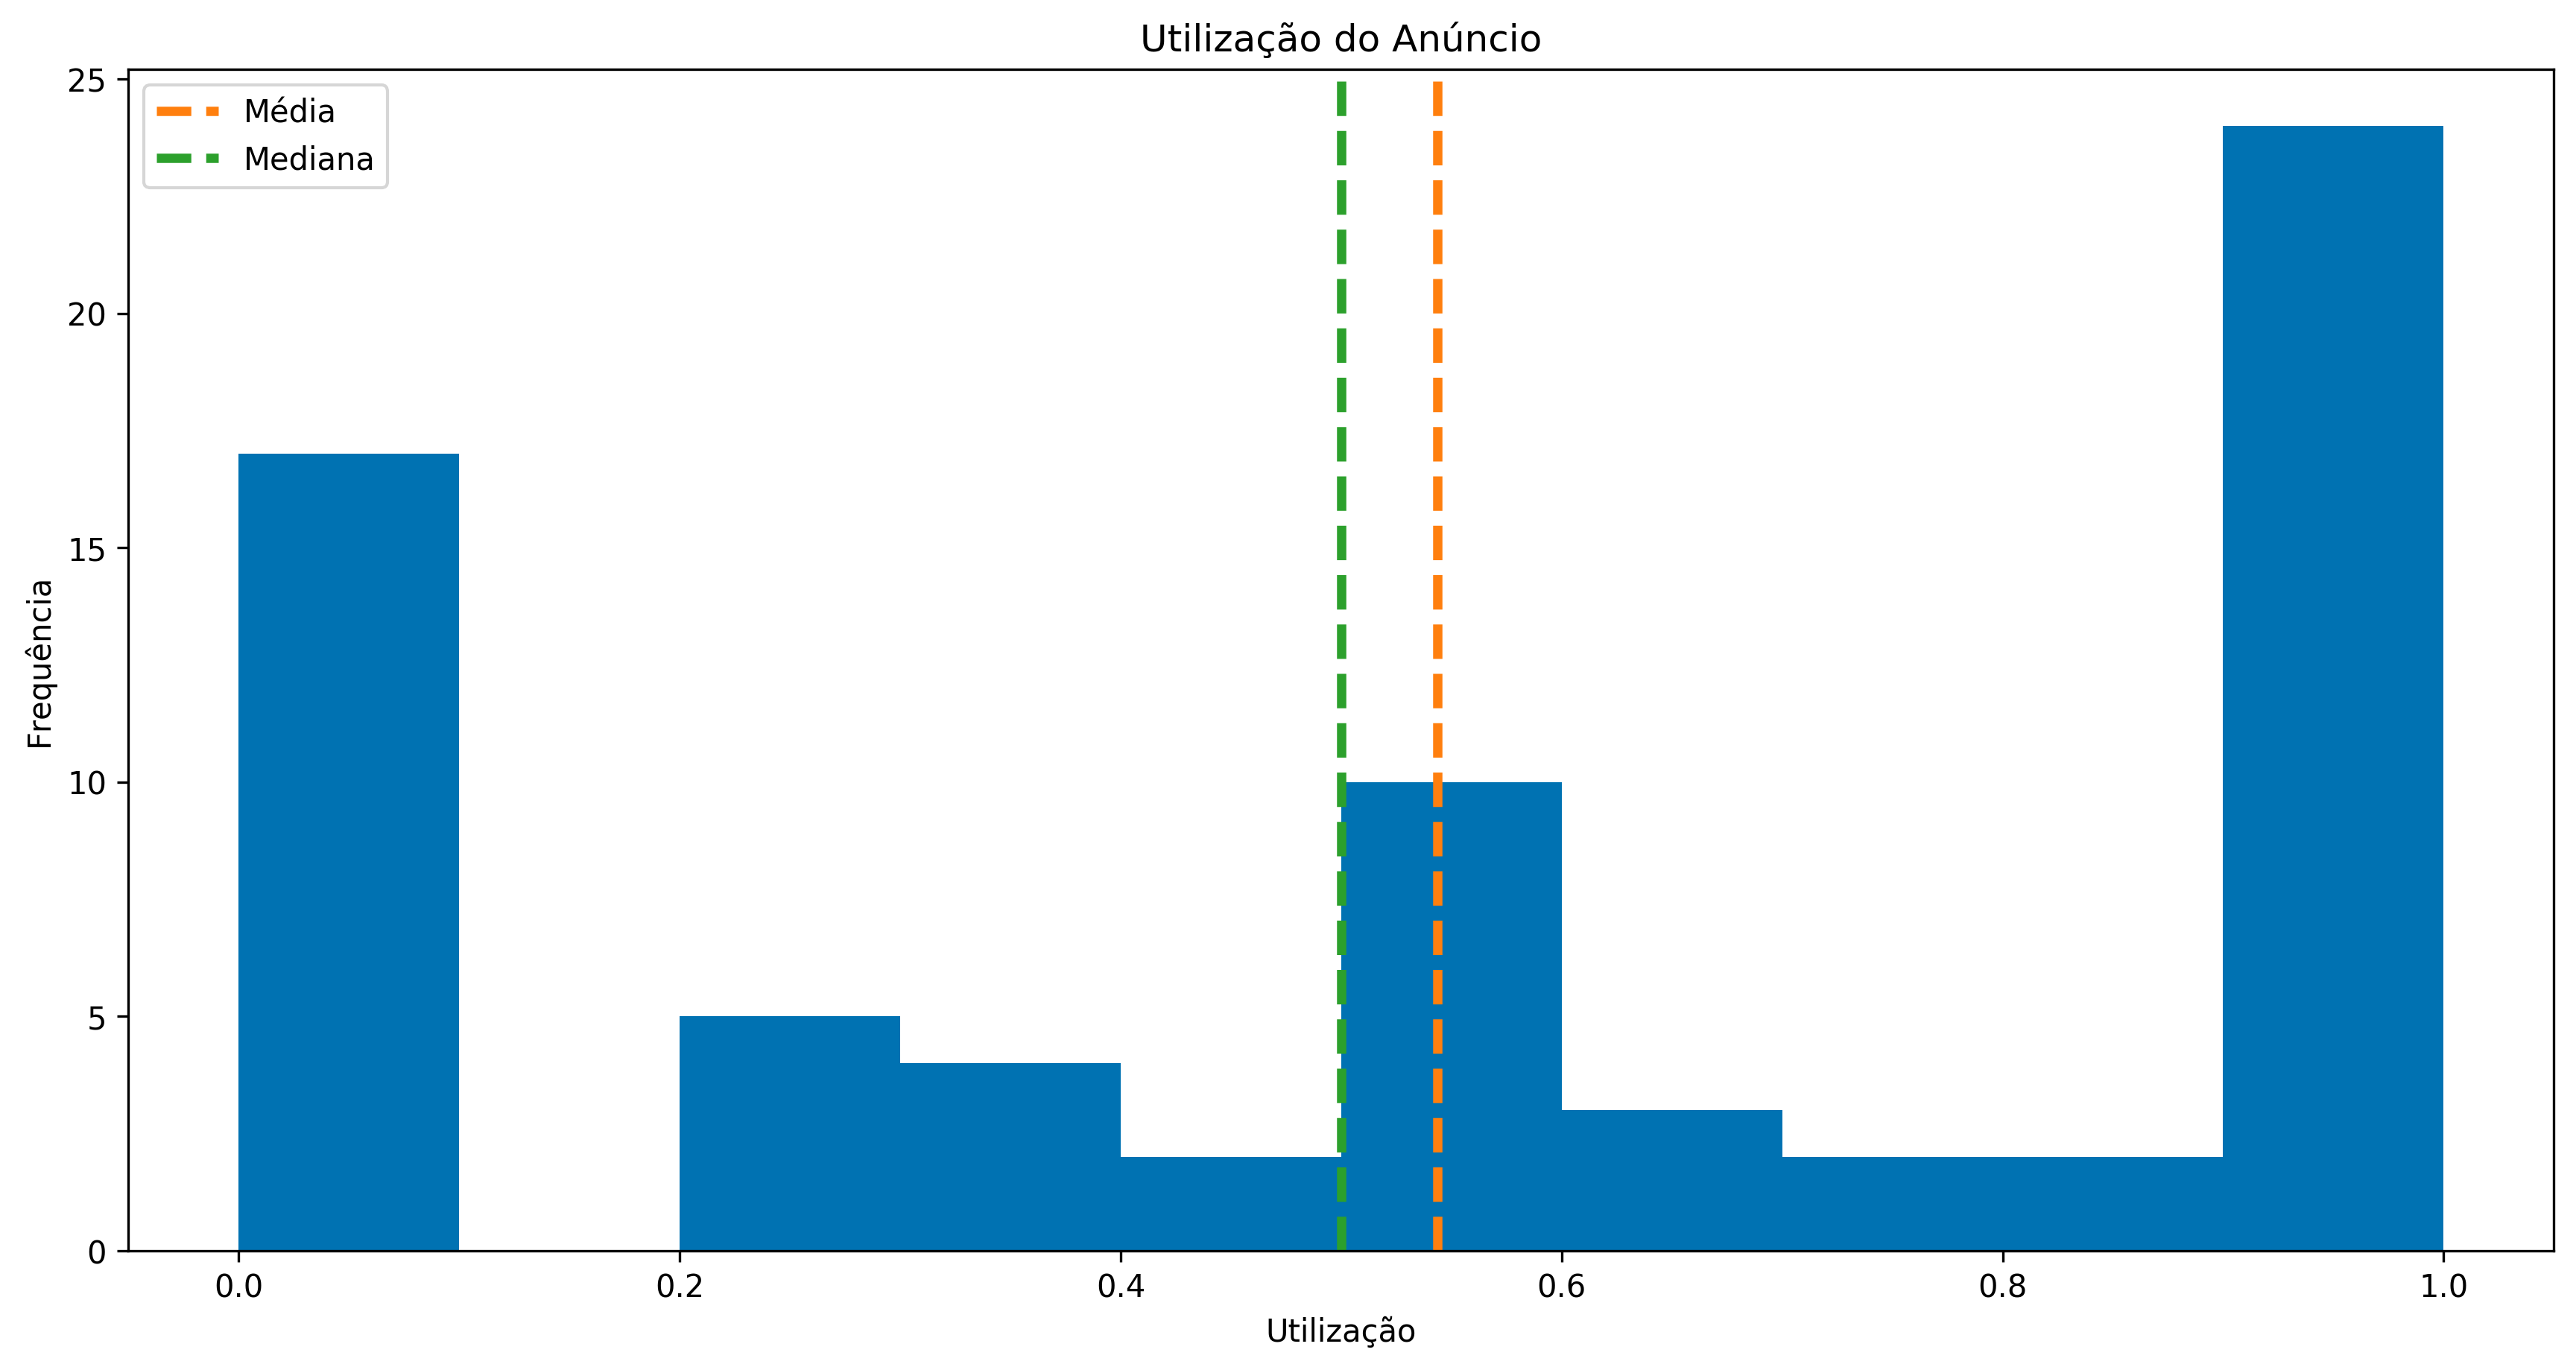

In [31]:
fig, ax = plt.subplots(figsize = (14, 7), dpi = 300)

values = anuncio_utilisation.values()
ax.hist(values)

ylims = ax.get_ylim()
ax.vlines(np.mean(list(values)), *ylims, "tab:orange", "dashed", label = "Média", lw = 3)
ax.vlines(np.median(list(values)), *ylims, "tab:green", "dashed", label = "Mediana", lw = 3)
ax.set_ylim(*ylims)

ax.set_xlabel("Utilização")
ax.set_ylabel("Frequência")
ax.set_title("Utilização do Anúncio")
ax.legend()

A maioria dos anúncios foi repartida entre dois grupos:

1. Os muito populares
2. Os muito impopulares

Resultados como estes indicam quais anúncios devem ser eliminados do mix ou necessitam mais campanhas de divulgação.

### Influenciadores

Neste exemplo a análise mais valiosa é a dos influenciadores. Para isto vamos inverter o pareamento gerado pelo algoritmo:

In [32]:
inverted_matching = {}
influenciador_preference_of_matching = []
for anuncio, anuncio_influenciadores in matching.items():
    for influenciador in anuncio_influenciadores:
        inverted_matching[influenciador.name] = anuncio.name
        influenciador_preference_of_matching.append(influenciador._pref_names.index(anuncio.name))

Assim poderemos criar relacionamentos entre os dados de influenciadores pareados e os dados originais e extrair os que não foram pareados:

In [33]:
df_matching = pd.DataFrame(
    {
        "nome": list(inverted_matching.keys()),
        "anuncio_codigo": list(inverted_matching.values()),
        "preference": influenciador_preference_of_matching,
    }
)

df_matching = df_matching.sort_values(by = "nome").reset_index(drop = True)

nome_indexed_df_matching = df_matching.set_index("nome")
nome_indexed_raw_influenciadores = raw_influenciadores.set_index("nome")

df_matching = pd.concat(
    (nome_indexed_df_matching, nome_indexed_raw_influenciadores["rank"]), axis = 1
).reset_index()

In [34]:
unassigned_influenciadores = df_matching[df_matching["preference"].isnull()]

unassigned_influenciadores

,nome,anuncio_codigo,preference,rank
93,190025,NaN,NaN,89
94,190029,NaN,NaN,97
95,190035,NaN,NaN,99
96,190040,NaN,NaN,98
97,190041,NaN,NaN,72
98,190082,NaN,NaN,82
99,190087,NaN,NaN,65


In [35]:
assigned_influenciadores = df_matching[df_matching["preference"].notnull()]
assigned_influenciadores = assigned_influenciadores.astype({"preference": int})
assigned_influenciadores.head()

,nome,anuncio_codigo,preference,rank
0,190000,G2,0,3
1,190001,Q0,0,56
2,190002,U0,1,60
3,190003,C0,0,67
4,190004,I0,0,19


Baixo um gráfico mostrando a frequência da preferência do influenciador sobre seu pareamento:

Text(0.5, 1.0, 'Preferências do Influenciador')

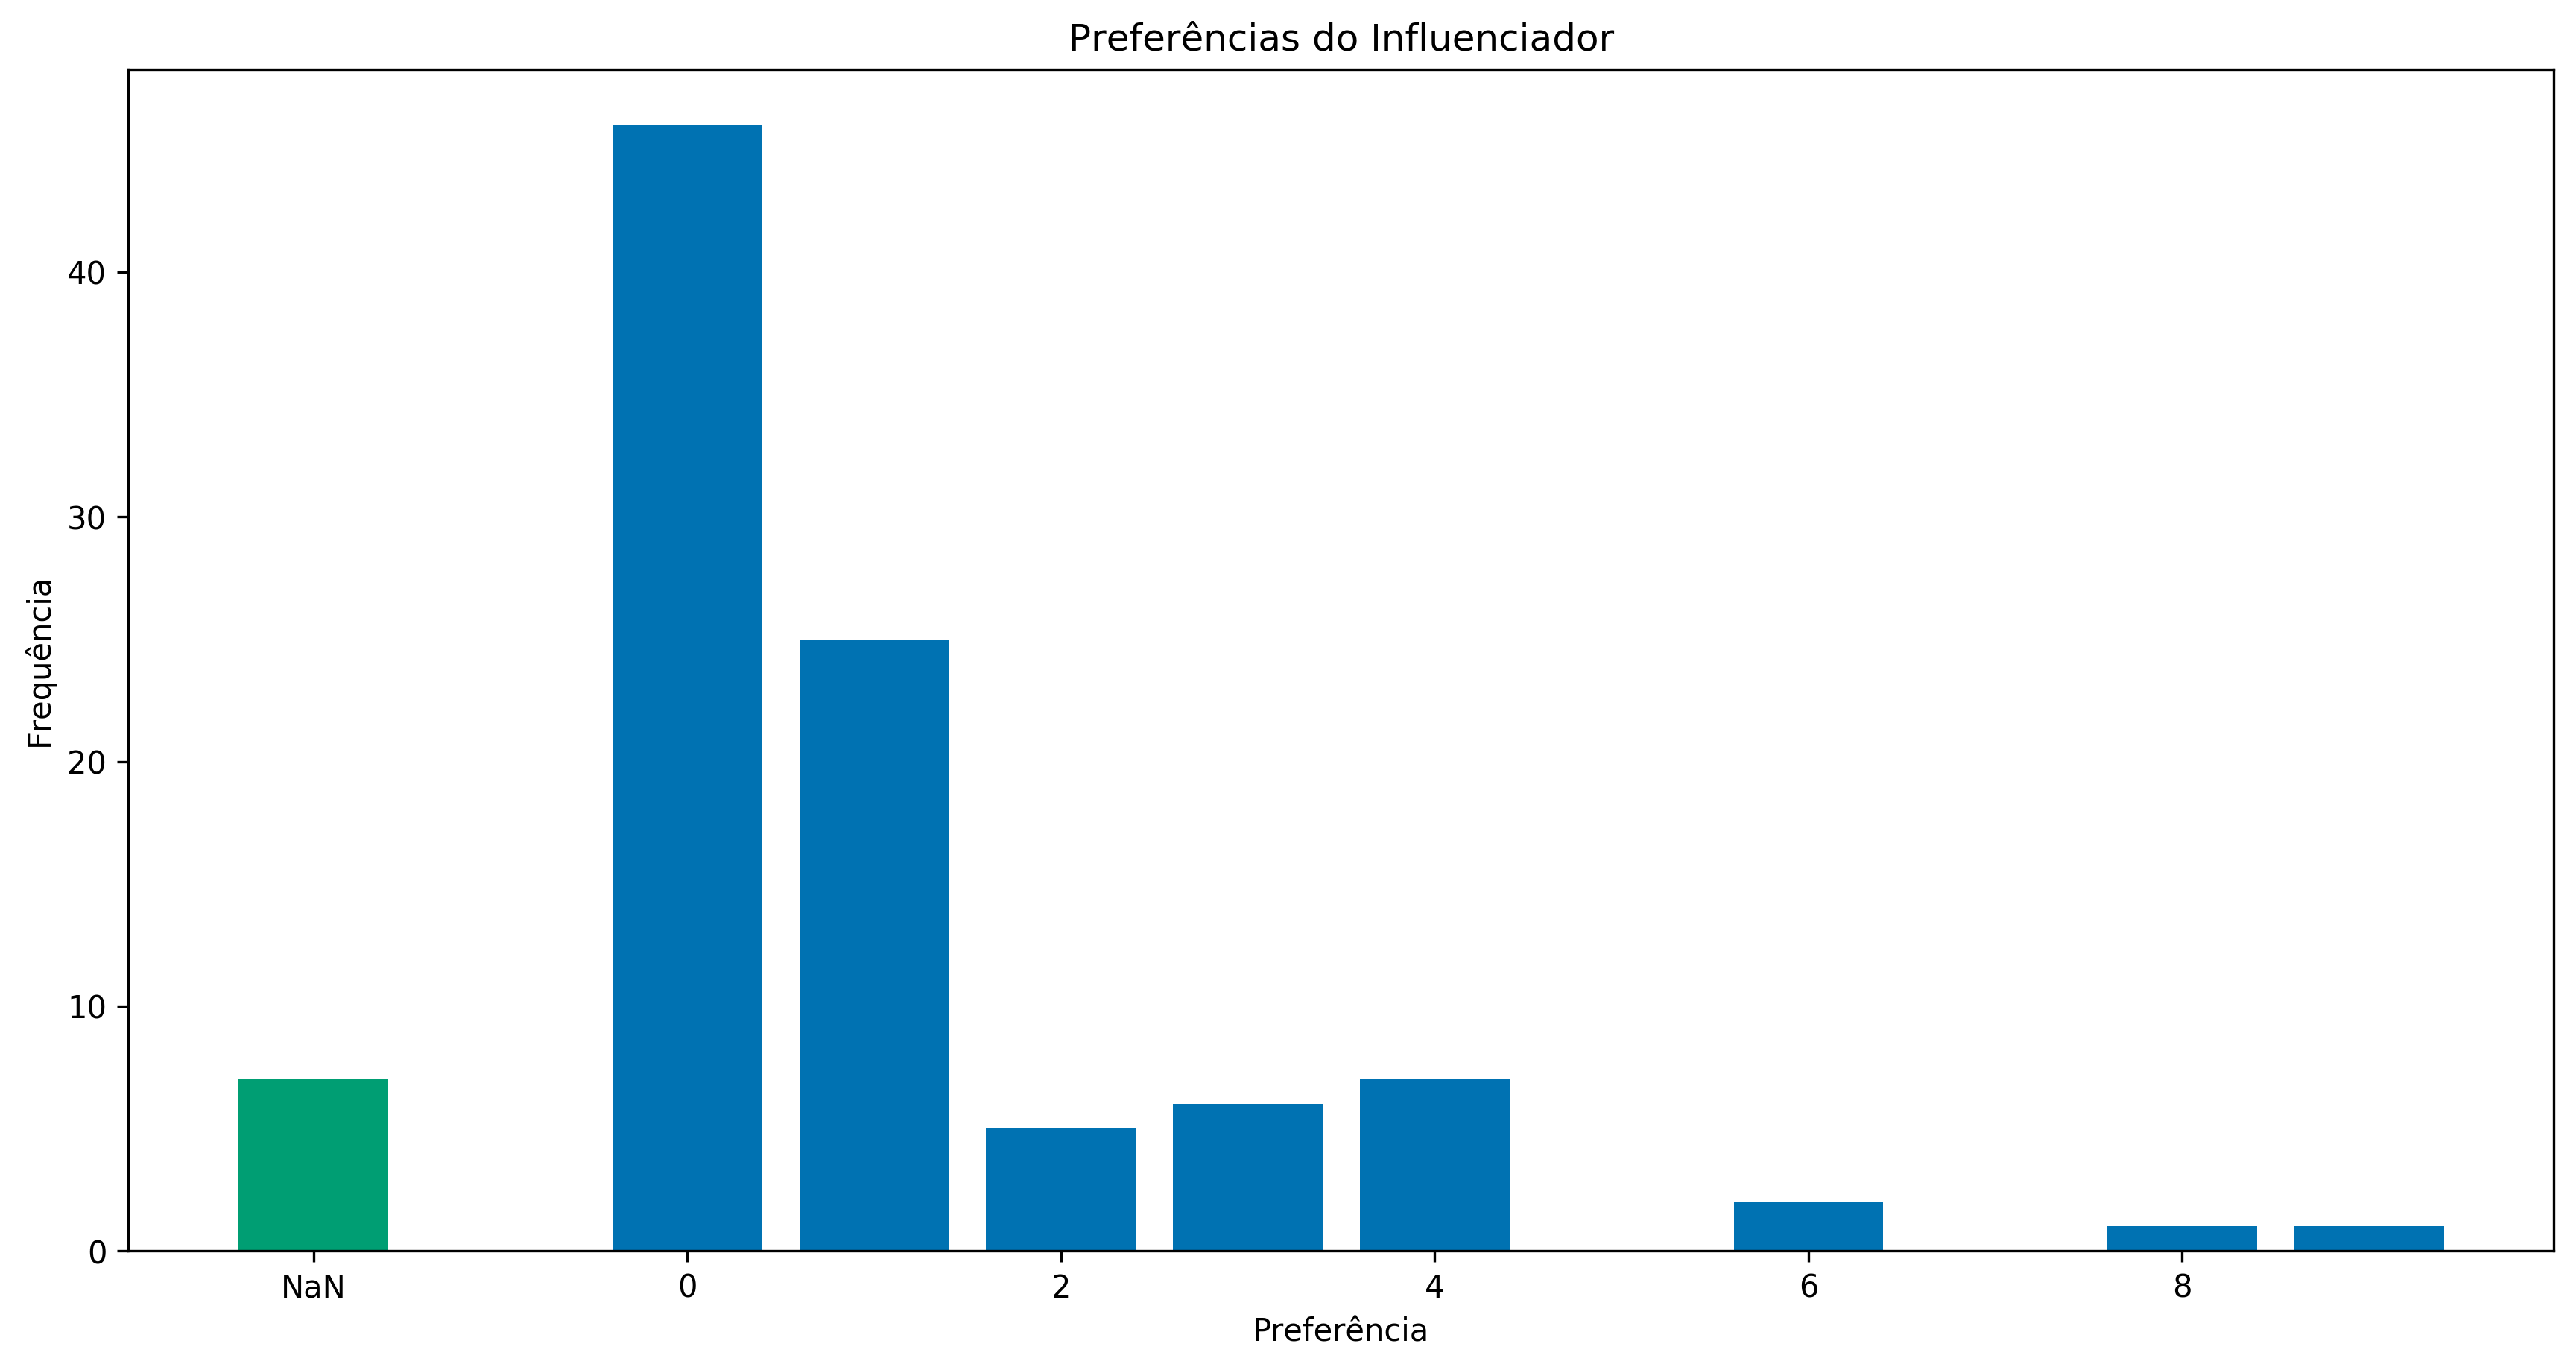

In [36]:
fig, ax = plt.subplots(figsize = (14, 7), dpi = 300)

values = Counter(assigned_influenciadores["preference"])
ax.bar(values.keys(), values.values())
ax.bar(-2, len(unassigned_influenciadores))

ax.set_xticks([-2] + list(range(0, 10, 2)))
ax.set_xticklabels(["NaN"] + list(range(0, 10, 2)))
ax.set_xlabel("Preferência")
ax.set_ylabel("Frequência")
ax.set_title("Preferências do Influenciador")

Podemos observar que a maioria dos influenciadores obteve sua primeira ou segunda opção.

Outra consideração importante é o quão apropriado o _**ranking**_ é. Idealmente o influenciador que está classificado entre os melhores deve obter as suas primeiras opções e conforme a qualificação desce do mesmo modo suas preferências também devem descer.

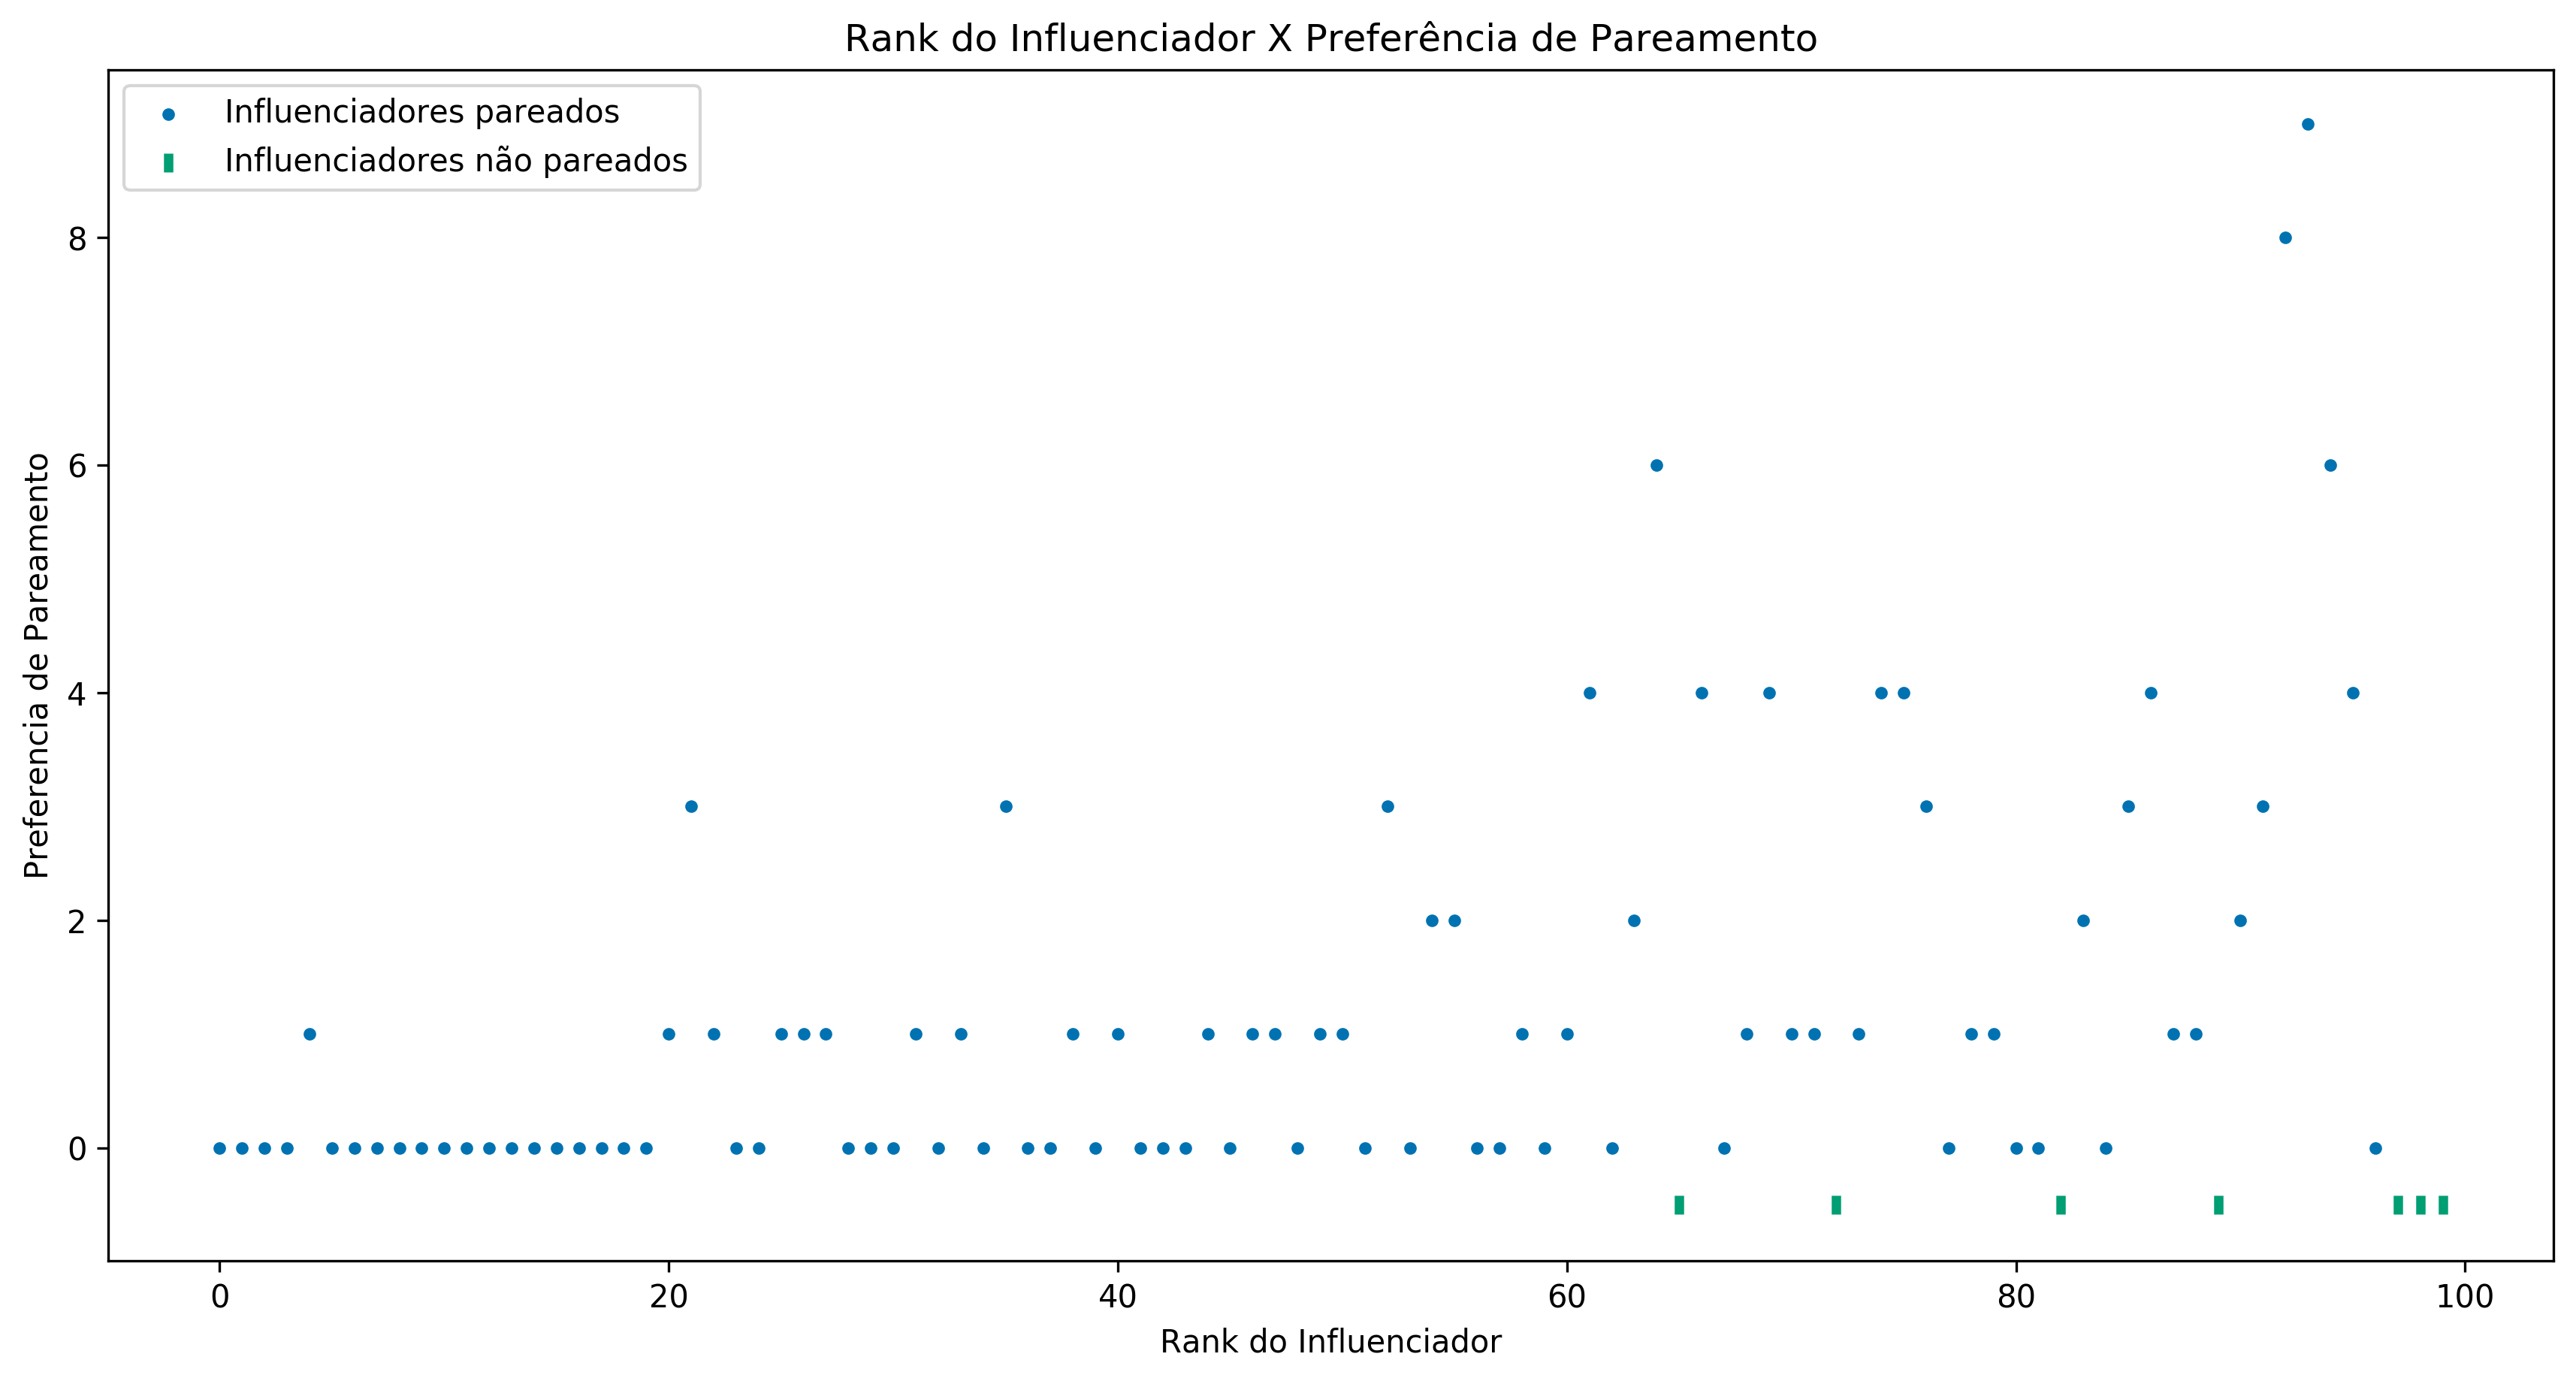

In [37]:
fig, ax = plt.subplots(figsize = (14, 7), dpi = 300)

ax.scatter(
    assigned_influenciadores["rank"],
    assigned_influenciadores["preference"],
    marker = ".",
    label = "Influenciadores pareados",
)

ax.scatter(
    unassigned_influenciadores["rank"],
    [-0.5] * len(unassigned_influenciadores),
    marker = "|",
    lw = 3,
    label = "Influenciadores não pareados",
)

ax.set_xlabel("Rank do Influenciador")
ax.set_ylabel("Preferencia de Pareamento")
ax.set_title("Rank do Influenciador X Preferência de Pareamento")
ax.legend()

## Observando vagas remanescentes

Ajustes podem (mas não devem) ser feitos na alocação. Uma possibilidade é oferecer anúncios com espaços vagos para influenciadores que não receberam ofertas:

In [38]:
import warnings

warnings.filterwarnings("ignore")

In [39]:
anuncio_com_vagas_nomes = [
    anuncio.name
    for anuncio in game.resources
    if len(anuncio.matching) < anuncio.capacity
] + list(unranked_anuncios)

comerciante_com_vagas_nomes = [
    comerciante.name
    for comerciante in game.containers
    if len(comerciante.matching) < comerciante.capacity
] + list(unranked_comerciantes)

In [40]:
def get_number_of_pareamentos(nome, party, game):

    for player in vars(game)[party]:
        if player.name == nome:
            return len(player.matching)

    return 0


def get_quota(data, party, nome):

    if party == "anuncio":
        column = "codigo"
    else:
        column = "nome"

    return data[data[column] == nome]["quota"].iloc[0]

In [41]:
anuncios_com_vagas = anuncios[
    (anuncios["codigo"].isin(anuncio_com_vagas_nomes))
    & (anuncios["comerciante"].isin(comerciante_com_vagas_nomes))
]

In [42]:
anuncios_com_vagas["comerciante_quota"] = anuncios_com_vagas["comerciante"].apply(
    lambda x: get_quota(comerciantes, "comerciante", x)
)

anuncios_com_vagas["anuncio_pareamentos"] = anuncios_com_vagas["codigo"].apply(
    lambda x: get_number_of_pareamentos(x, "resources", game)
)

anuncios_com_vagas["comerciante_pareamentos"] = anuncios_com_vagas["comerciante"].apply(
    lambda x: get_number_of_pareamentos(x, "containers", game)
)

anuncios_com_vagas = anuncios_com_vagas[
    [
        "codigo",
        "quota",
        "anuncio_pareamentos",
        "comerciante",
        "comerciante_quota",
        "comerciante_pareamentos",
    ]
]

In [43]:
anuncios_com_vagas = anuncios_com_vagas.set_index(["comerciante", "codigo"]).sort_index()

anuncios_com_vagas

quota  anuncio_pareamentos  comerciante_quota  \
comerciante codigo                                                  
C           C0          8                    2                  8   
            C2          4                    2                  8   
M           M0          8                    2                  7   
Z           Z0          5                    1                  5   

                    comerciante_pareamentos  
comerciante codigo                           
C           C0                            5  
            C2                            5  
M           M0                            5  
Z           Z0                            3

> Fim